In [1]:
cd ../related_post_gen/python

/Users/fizmat/Desktop/related_post_gen/python


In [2]:
from sh import git, python
from glob import iglob
import pandas as pd
from io import StringIO
from tqdm.notebook import tqdm

In [3]:
INPUT_COLUMNS = ["counter", "import", "input", "process", "output"]
TIME_COLUMNS = ["import", "input", "process", "output"]

In [4]:
GLOB = "related*.py"

In [5]:
# COMMITS = ["scipy-partition", "numba", "test-partition", "dataframes", "^start"]
COMMITS = ["start..test-partition"]

In [6]:
N = 100

In [7]:
def collect_times(commits=COMMITS, glob=GLOB, n=N, input_columns=INPUT_COLUMNS, time_columns=TIME_COLUMNS):
    data = []
    for i, h in enumerate(git("rev-list", "--reverse", *commits, "--", _tty_out=False).splitlines()):
        print(git.checkout(h))
        subj = git.show("-s", "--format=%s", _tty_out=False).strip()
        subj = f"{i}: {subj}"
        print(subj)
        for f in iglob(glob):
            print(f)
            # warm-up
            print(python(f))
            python(f)
            # measure
            buf = "\n".join(python(f, _tty_out=False).strip() for _ in tqdm(range(n)))
            record = pd.read_csv(StringIO(buf), sep="\t", header=None, names=input_columns)
            record["impl"] = f
            record["commit"] = subj
            data.append(record)
    times = pd.concat(data)
    times["total"] = times[time_columns].sum(axis=1)
    return times


In [8]:
from uncertainties import ufloat

def pretty_stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: f"{ufloat(c.mean(), c.std()):.2ufP}")

def report(times):
    table = times.groupby(["impl", "counter", "commit"]).apply(pretty_stddev)
    return table


In [9]:
import seaborn as sns

def plot(times):
    tidy = times.melt(id_vars=["impl", "commit", "counter"],
                      var_name="section", value_name="time")
    grid = sns.catplot(tidy, hue="section", y="commit", x="time",
                       row="impl", col="counter", kind="point")
    for arr in grid.axes:
        for ax in arr:
            ax.set_xscale("log")


In [10]:
times = collect_times()


0: minor pythonizations: deafultdict, no need for heapq
related.py
perf_counter	0.004375624994281679	0.004092874994967133	1.2469607500243	0.11014654202153906
process_time	0.004376	0.004091999999999998	1.246921	0.10812400000000011



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.08874924998963252	0.004096458025742322	0.5420117079629563	0.11535625002579764
process_time	0.05132	0.004096000000000002	0.532278	0.10909400000000002



  0%|          | 0/100 [00:00<?, ?it/s]


1: use ujson for IO
related.py
perf_counter	0.006254415959119797	0.004032334021758288	1.256361083011143	0.020020166994072497
process_time	0.0032270000000000007	0.0039380000000000005	1.2557649999999998	0.017125000000000057



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.08951108303153887	0.0035488339490257204	0.5441842080326751	0.020483249973040074
process_time	0.051556	0.0035480000000000025	0.535857	0.017459000000000002



  0%|          | 0/100 [00:00<?, ?it/s]


2: np: use python set to list unique_tags
related.py
perf_counter	0.0025906250230036676	0.003767582995351404	1.2463690000004135	0.020192875002976507
process_time	0.0025909999999999996	0.0037669999999999995	1.245801	0.01701599999999992



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.0904112919815816	0.0036261670175008476	0.5134876659722067	0.02169416705146432
process_time	0.052073999999999995	0.0036250000000000032	0.5133449999999999	0.01805800000000002



  0%|          | 0/100 [00:00<?, ?it/s]


3: np: use smaller matrix dtype
related.py
perf_counter	0.0030391669715754688	0.0037880000309087336	1.2549100409960374	0.020565958984661847
process_time	0.002666	0.0037879999999999997	1.254411	0.017169999999999908



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.09586916700936854	0.0035968750016763806	0.4946545410202816	0.021754166984464973
process_time	0.053577999999999994	0.003596000000000002	0.492086	0.017415999999999987



  0%|          | 0/100 [00:00<?, ?it/s]


4: use dict of tags to generate matrix
related.py
perf_counter	0.0026230000075884163	0.003831708978395909	1.2588542079902254	0.020386542018968612
process_time	0.0026230000000000003	0.0038309999999999993	1.2583689999999998	0.01730699999999996



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.0893154590157792	0.003743082983419299	0.4754487500176765	0.021188249986153096
process_time	0.051361	0.0037429999999999963	0.473225	0.01820200000000005



  0%|          | 0/100 [00:00<?, ?it/s]


5: try to use numpy partition instead of sorting
related.py
perf_counter	0.002821834001224488	0.004095666052307934	1.25760245899437	0.02026095800101757
process_time	0.0028210000000000006	0.004095999999999999	1.257005	0.017239000000000004



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.08990358398295939	0.0036451250198297203	0.5229915829841048	0.024449958000332117
process_time	0.052094	0.0036430000000000073	0.516394	0.01915800000000001



  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
report(times)

import  \
impl          counter      commit                                                            
related.py    perf_counter 0: minor pythonizations: deafultdict, no need f...    4.65±0.49   
                           1: use ujson for IO                                   2.83±0.55   
                           2: np: use python set to list unique_tags             2.78±0.43   
                           3: np: use smaller matrix dtype                       2.83±0.82   
                           4: use dict of tags to generate matrix                2.78±0.54   
                           5: try to use numpy partition instead of sorting      2.75±0.50   
              process_time 0: minor pythonizations: deafultdict, no need f...    4.48±0.23   
                           1: use ujson for IO                                   2.70±0.24   
                           2: np: use python set to list unique_tags             2.66±0.11   
                           3: np: use smaller matrix dtype                       2.68±0.15   
                           4: use dict of tags to generate matrix              2.648±0.086   
                           5: try to use numpy partition instead of sorting      2.66±0.11   
related_np.py perf_counter 0: minor pythonizations: deafultdict, no need f...     47.3±2.8   
                           1: use ujson for IO                                    48.4±2.6   
                           2: np: use python set to list unique_tags              48.2±2.0   
                           3: np: use smaller matrix dtype                        48.2±2.7   
                           4: use dict of tags to generate matrix                 48.2±2.2   
                           5: try to use numpy partition instead of sorting       48.1±2.2   
              process_time 0: minor pythonizations: deafultdict, no need f...     46.6±1.2   
                           1: use ujson for IO                                  47.92±0.75   
                           2: np: use python set to list unique_tags            47.84±0.77   
                           3: np: use smaller matrix dtype                        47.8±1.2   
                           4: use dict of tags to generate matrix               47.84±0.91   
                           5: try to use numpy partition instead of sorting     47.81±0.70   

                                                                                     input  \
impl          counter      commit                                                            
related.py    perf_counter 0: minor pythonizations: deafultdict, no need f...    4.11±0.16   
                           1: use ujson for IO                                   3.90±0.27   
                           2: np: use python set to list unique_tags           3.861±0.094   
                           3: np: use smaller matrix dtype                       3.88±0.26   
                           4: use dict of tags to generate matrix                3.90±0.16   
                           5: try to use numpy partition instead of sorting      3.89±0.14   
              process_time 0: minor pythonizations: deafultdict, no need f...    4.11±0.15   
                           1: use ujson for IO                                   3.89±0.20   
                           2: np: use python set to list unique_tags           3.861±0.095   
                           3: np: use smaller matrix dtype                       3.86±0.11   
                           4: use dict of tags to generate matrix                3.90±0.15   
                           5: try to use numpy partition instead of sorting      3.89±0.14   
related_np.py perf_counter 0: minor pythonizations: deafultdict, no need f...    4.16±0.12   
                           1: use ujson for IO                                 3.629±0.051   
                           2: np: use python set to list unique_tags           3.641±0.063   
                           3: np: use sma

/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

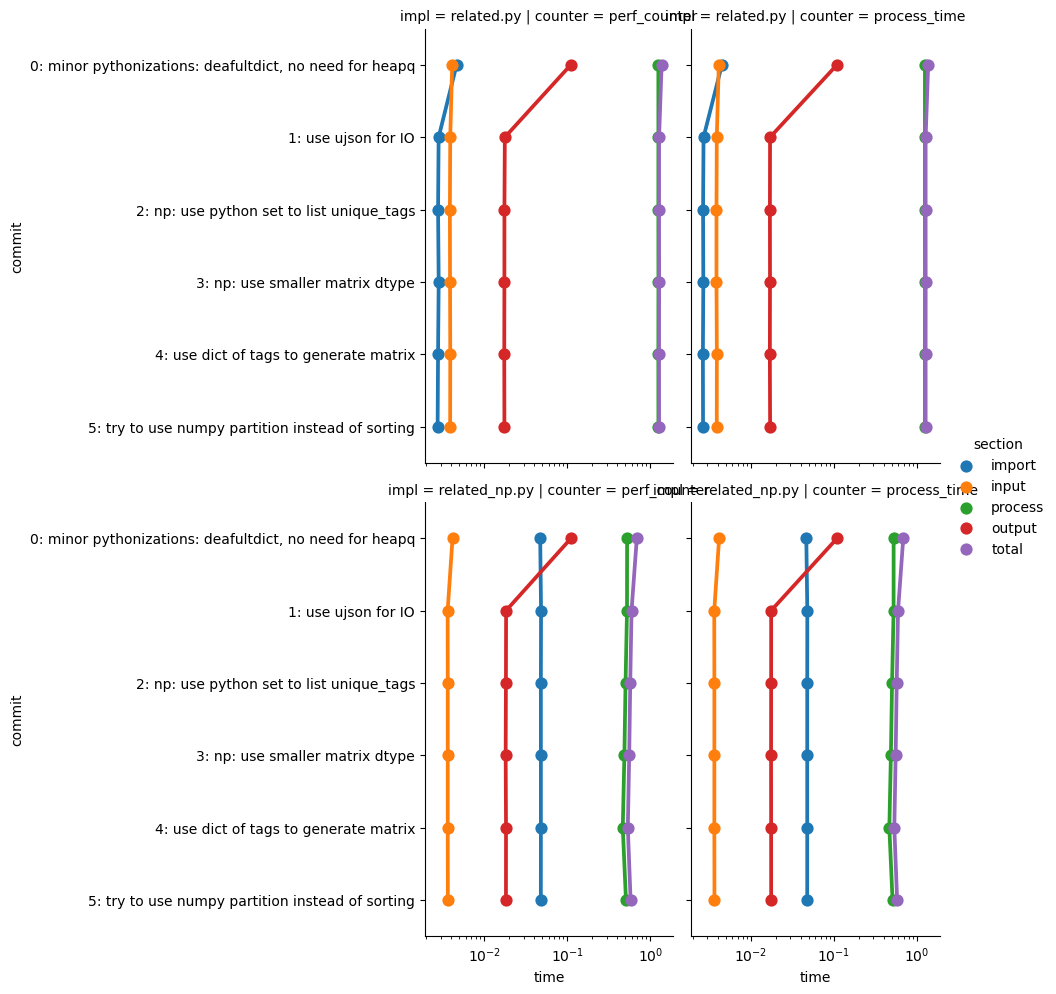

In [12]:
plot(times)

In [13]:
times_scipy = collect_times(["python..scipy-partition"])
print(times_scipy.info())


0: copy numpy matrix solution
related.py
perf_counter	0.0027852909988723695	0.0038409170228987932	1.252278166997712	0.02067895798245445
process_time	0.0026409999999999993	0.0038410000000000007	1.251272	0.017551000000000094



  0%|          | 0/100 [00:00<?, ?it/s]

related_scipy.py
perf_counter	0.09662429202580824	0.003830457979347557	0.47577037499286234	0.022152542020194232
process_time	0.052635	0.003819000000000003	0.473622	0.018359000000000014



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.047359083022456616	0.0036348329740576446	0.46681491704657674	0.020108999975491315
process_time	0.047462	0.0036300000000000013	0.466782	0.01844699999999999



  0%|          | 0/100 [00:00<?, ?it/s]


1: use scipy sparse matrix
related.py
perf_counter	0.0025909580290317535	0.003783959022257477	1.252401582954917	0.018983125046361238
process_time	0.0025900000000000003	0.003785	1.251844	0.016925999999999997



  0%|          | 0/100 [00:00<?, ?it/s]

related_scipy.py
perf_counter	0.18168533395510167	0.003613915992900729	0.29452141700312495	0.02184658299665898
process_time	0.090143	0.0036129999999999912	0.286217	0.017664000000000013



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.047948500025086105	0.0035858749761246145	0.46330229099839926	0.02012095903046429
process_time	0.048048	0.003585999999999992	0.46329500000000007	0.017302999999999957



  0%|          | 0/100 [00:00<?, ?it/s]


2: sort results directly in sparse matrix internals
related.py
perf_counter	0.0027930420474149287	0.003816832962911576	1.2626522090286016	0.01932374999159947
process_time	0.002661	0.003818	1.262211	0.01732200000000006



  0%|          | 0/100 [00:00<?, ?it/s]

related_scipy.py
perf_counter	0.15033762500388548	0.0036195419961586595	0.2325015419628471	0.022399916022550315
process_time	0.085509	0.0036199999999999982	0.231779	0.017581999999999987



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.047558374993968755	0.0036482500145211816	0.4969912499655038	0.02101412502815947
process_time	0.047653	0.0036470000000000044	0.481444	0.017947000000000046



  0%|          | 0/100 [00:00<?, ?it/s]


3: try to use numpy partition instead of sorting
related.py
perf_counter	0.003090500016696751	0.003917958005331457	1.247765249980148	0.017977749987039715
process_time	0.002876	0.003918000000000001	1.2472560000000001	0.017091999999999885



  0%|          | 0/100 [00:00<?, ?it/s]

related_scipy.py
perf_counter	0.21218762500211596	0.004016083024907857	0.23107916698791087	0.01970487501239404
process_time	0.098328	0.003983	0.22868299999999997	0.01683800000000002



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.04699958401033655	0.003589165979065001	0.47249850002117455	0.02169712499016896
process_time	0.047098	0.003590000000000003	0.472473	0.01816300000000004



  0%|          | 0/100 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   counter  2400 non-null   object 
 1   import   2400 non-null   float64
 2   input    2400 non-null   float64
 3   process  2400 non-null   float64
 4   output   2400 non-null   float64
 5   impl     2400 non-null   object 
 6   commit   2400 non-null   object 
 7   total    2400 non-null   float64
dtypes: float64(5), object(3)
memory usage: 168.8+ KB
None


In [14]:
report(times_scipy)

import  \
impl             counter      commit                                                            
related.py       perf_counter 0: copy numpy matrix solution                         2.77±0.48   
                              1: use scipy sparse matrix                            2.84±0.55   
                              2: sort results directly in sparse matrix inter...    2.77±0.40   
                              3: try to use numpy partition instead of sorting      2.80±0.41   
                 process_time 0: copy numpy matrix solution                         2.65±0.11   
                              1: use scipy sparse matrix                            2.69±0.15   
                              2: sort results directly in sparse matrix inter...  2.640±0.085   
                              3: try to use numpy partition instead of sorting      2.67±0.13   
related_np.py    perf_counter 0: copy numpy matrix solution                          48.3±2.6   
                              1: use scipy sparse matrix                             48.3±2.8   
                              2: sort results directly in sparse matrix inter...     48.4±2.9   
                              3: try to use numpy partition instead of sorting       47.7±2.1   
                 process_time 0: copy numpy matrix solution                        47.71±0.72   
                              1: use scipy sparse matrix                           47.74±0.77   
                              2: sort results directly in sparse matrix inter...     47.9±1.5   
                              3: try to use numpy partition instead of sorting     47.39±0.80   
related_scipy.py perf_counter 0: copy numpy matrix solution                          48.0±2.1   
                              1: use scipy sparse matrix                             77.7±3.2   
                              2: sort results directly in sparse matrix inter...     77.2±3.2   
                              3: try to use numpy partition instead of sorting       78.3±4.0   
                 process_time 0: copy numpy matrix solution                        47.67±0.81   
                              1: use scipy sparse matrix                             77.1±1.3   
                              2: sort results directly in sparse matrix inter...     76.7±1.2   
                              3: try to use numpy partition instead of sorting       77.4±2.1   

                                                                                        input  \
impl             counter      commit                                                            
related.py       perf_counter 0: copy numpy matrix solution                         3.86±0.17   
                              1: use scipy sparse matrix                            3.92±0.49   
                              2: sort results directly in sparse matrix inter...  3.830±0.055   
                              3: try to use numpy partition instead of sorting      3.91±0.21   
                 process_time 0: copy numpy matrix solution                         3.86±0.14   
                              1: use scipy sparse matrix                            3.89±0.18   
                              2: sort results directly in sparse matrix inter...  3.830±0.055   
                              3: try to use numpy partition instead of sorting      3.90±0.18   
related_np.py    perf_counter 0: copy numpy matrix solution                       3.633±0.059   
                              1: use scipy sparse matrix                          3.620±0.044   
                              2: sort results directly in sparse matrix inter...  3.650±0.078   
                              3: try to use numpy partition instead of sorting    3.629±0.077   
                 process_time 0: copy numpy matrix solution                       3.632±0.059   
                              1: use scipy sparse matrix                          3.619±0.044   
            

/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

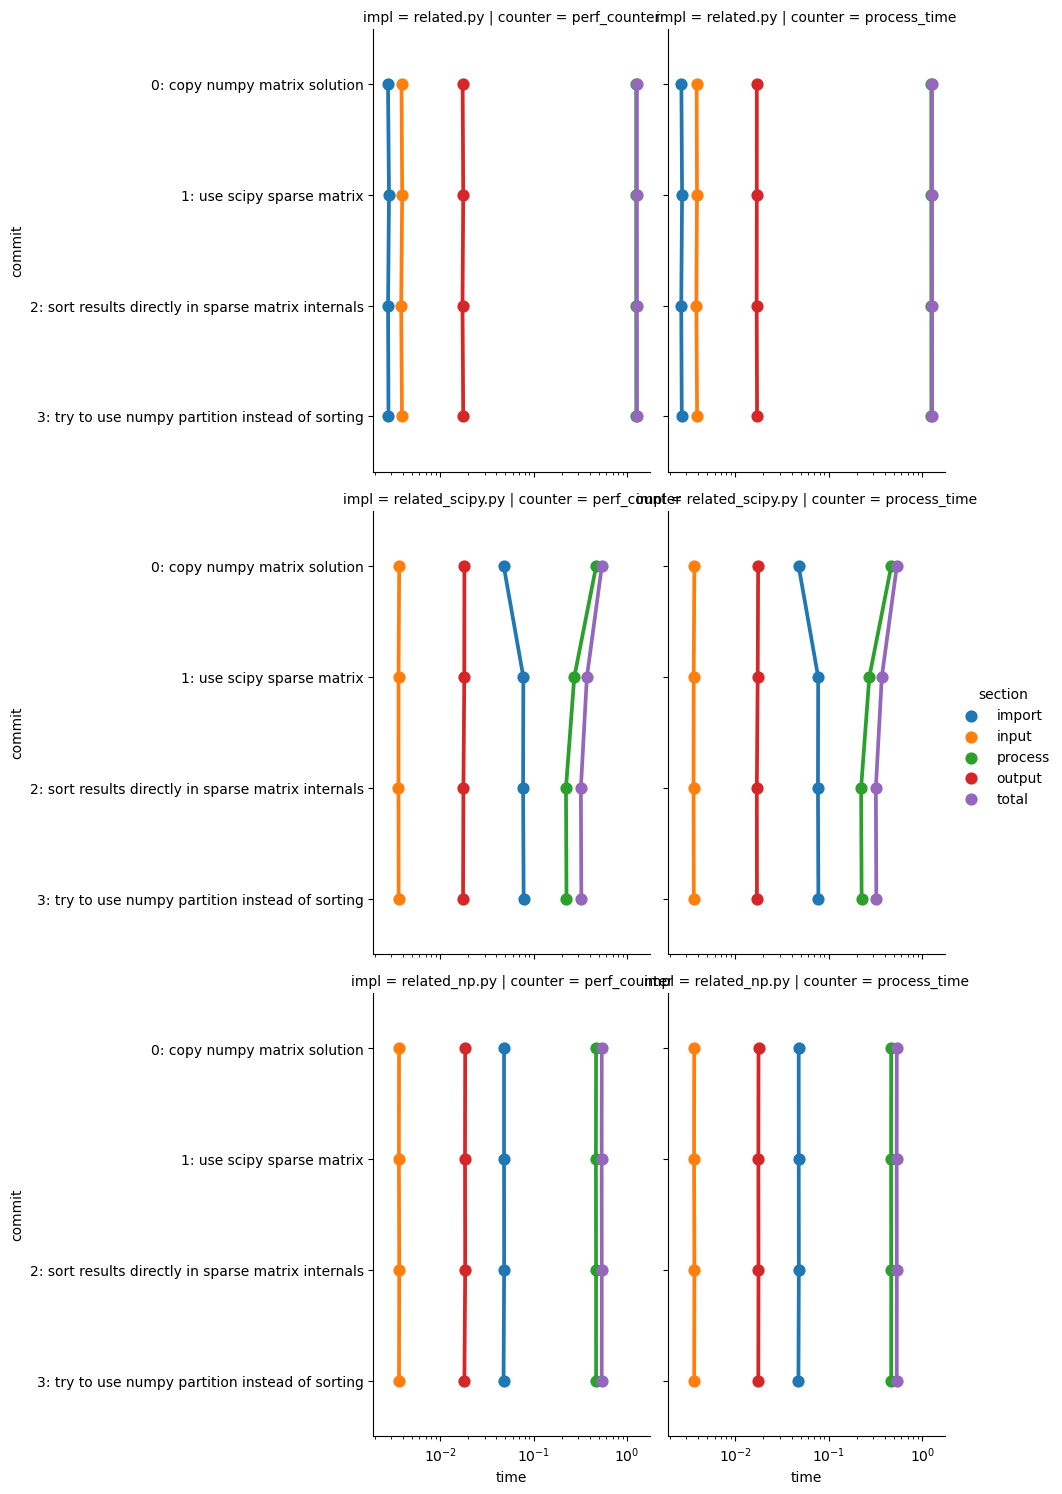

In [15]:
plot(times_scipy)

In [16]:
times_df = collect_times(["python..dataframes"])
print(times_df.info())


0: add python pandas variant
related.py
perf_counter	0.0028644169797189534	0.0038146660081110895	1.2563515839865431	0.02037275000475347
process_time	0.0026320000000000007	0.0038150000000000007	1.2537989999999999	0.017224000000000128



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.08922745898598805	0.003637665999121964	0.48732629197183996	0.022470667026937008
process_time	0.050850000000000006	0.0036370000000000013	0.482416	0.017959999999999976



  0%|          | 0/100 [00:00<?, ?it/s]

related_pd.py
perf_counter	0.44373174995416775	0.007725125004071742	5.6178899590158835	0.033387749979738146
process_time	0.264233	0.007439000000000029	5.088271	0.024887000000000548



  0%|          | 0/100 [00:00<?, ?it/s]


1: add python polars variant
related.py
perf_counter	0.0031178329954855144	0.003795791999436915	1.2589470829698257	0.022321125026792288
process_time	0.00281	0.003795999999999999	1.2589089999999998	0.017158000000000007



  0%|          | 0/100 [00:00<?, ?it/s]

related_pl.py
perf_counter	0.14314583397936076	0.011121458024717867	1.9131484169629402	0.012151583039667457
process_time	0.059232999999999994	0.003746000000000013	5.393002	0.009287999999999741



  0%|          | 0/100 [00:00<?, ?it/s]

related_np.py
perf_counter	0.13237620802829042	0.003795832977630198	0.48817387502640486	0.020617917005438358
process_time	0.061952	0.003795999999999994	0.48775399999999997	0.01794400000000007



  0%|          | 0/100 [00:00<?, ?it/s]

related_pd.py
perf_counter	0.47121662501012906	0.007929667015559971	5.380149874952622	0.024863333033863455
process_time	0.26429400000000003	0.007577999999999974	4.9316320000000005	0.022063000000000166



  0%|          | 0/100 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 1400 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   counter  1400 non-null   object 
 1   import   1400 non-null   float64
 2   input    1400 non-null   float64
 3   process  1400 non-null   float64
 4   output   1400 non-null   float64
 5   impl     1400 non-null   object 
 6   commit   1400 non-null   object 
 7   total    1400 non-null   float64
dtypes: float64(5), object(3)
memory usage: 98.4+ KB
None


In [17]:
report(times_df)

import  \
impl          counter      commit                                      
related.py    perf_counter 0: add python pandas variant    2.75±0.47   
                           1: add python polars variant      3.3±1.5   
              process_time 0: add python pandas variant  2.633±0.074   
                           1: add python polars variant    2.73±0.24   
related_np.py perf_counter 0: add python pandas variant     47.7±2.2   
                           1: add python polars variant     47.7±1.7   
              process_time 0: add python pandas variant     47.4±1.0   
                           1: add python polars variant   47.50±0.97   
related_pd.py perf_counter 0: add python pandas variant       266±61   
                           1: add python polars variant       260±26   
              process_time 0: add python pandas variant    231.3±2.9   
                           1: add python polars variant    232.7±4.9   
related_pl.py perf_counter 1: add python polars variant     47.1±3.5   
              process_time 1: add python polars variant     46.3±1.7   

                                                               input  \
impl          counter      commit                                      
related.py    perf_counter 0: add python pandas variant  3.833±0.074   
                           1: add python polars variant    3.88±0.40   
              process_time 0: add python pandas variant  3.832±0.074   
                           1: add python polars variant    3.87±0.28   
related_np.py perf_counter 0: add python pandas variant  3.623±0.038   
                           1: add python polars variant  3.639±0.057   
              process_time 0: add python pandas variant  3.621±0.038   
                           1: add python polars variant  3.638±0.057   
related_pd.py perf_counter 0: add python pandas variant    7.22±0.10   
                           1: add python polars variant    7.27±0.15   
              process_time 0: add python pandas variant    7.22±0.10   
                           1: add python polars variant    7.26±0.14   
related_pl.py perf_counter 1: add python polars variant    2.37±0.14   
              process_time 1: add python polars variant    2.36±0.10   

                                                            process  \
impl          counter      commit                                     
related.py    perf_counter 0: add python pandas variant  1253.1±5.8   
                           1: add python polars variant     1259±23   
              process_time 0: add python pandas variant  1252.4±4.9   
                           1: add python polars variant     1257±15   
related_np.py perf_counter 0: add python pandas variant      467±14   
                           1: add python polars variant   464.0±2.9   
              process_time 0: add python pandas variant   465.7±6.3   
                           1: add python polars variant   464.0±2.9   
related_pd.py perf_counter 0: add python pandas variant    5176±137   
                           1: add python polars variant    5192±155   
              process_time 0: add python pandas variant     4860±84   
                           1: add python polars variant    4876±107   
related_pl.py perf_counter 1: add python polars variant    1172±124   
              process_time 1: add python polars variant    4425±156   

                                                             output  \
impl          counter      commit                                     
related.py    perf_counter 0: add python pandas variant  17.68±0.78   
                           1: add python polars variant    19.6±6.9   
              process_time 0: add python pandas variant  17.06±0.32   
                           1: add python polars variant    17.3±1.8   
related_np.py perf_counter 0: add python pandas variant    18.2±1.6   
                           1: add python polars variant  17.92±0.95   
              process_time 0: add python pandas var

/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

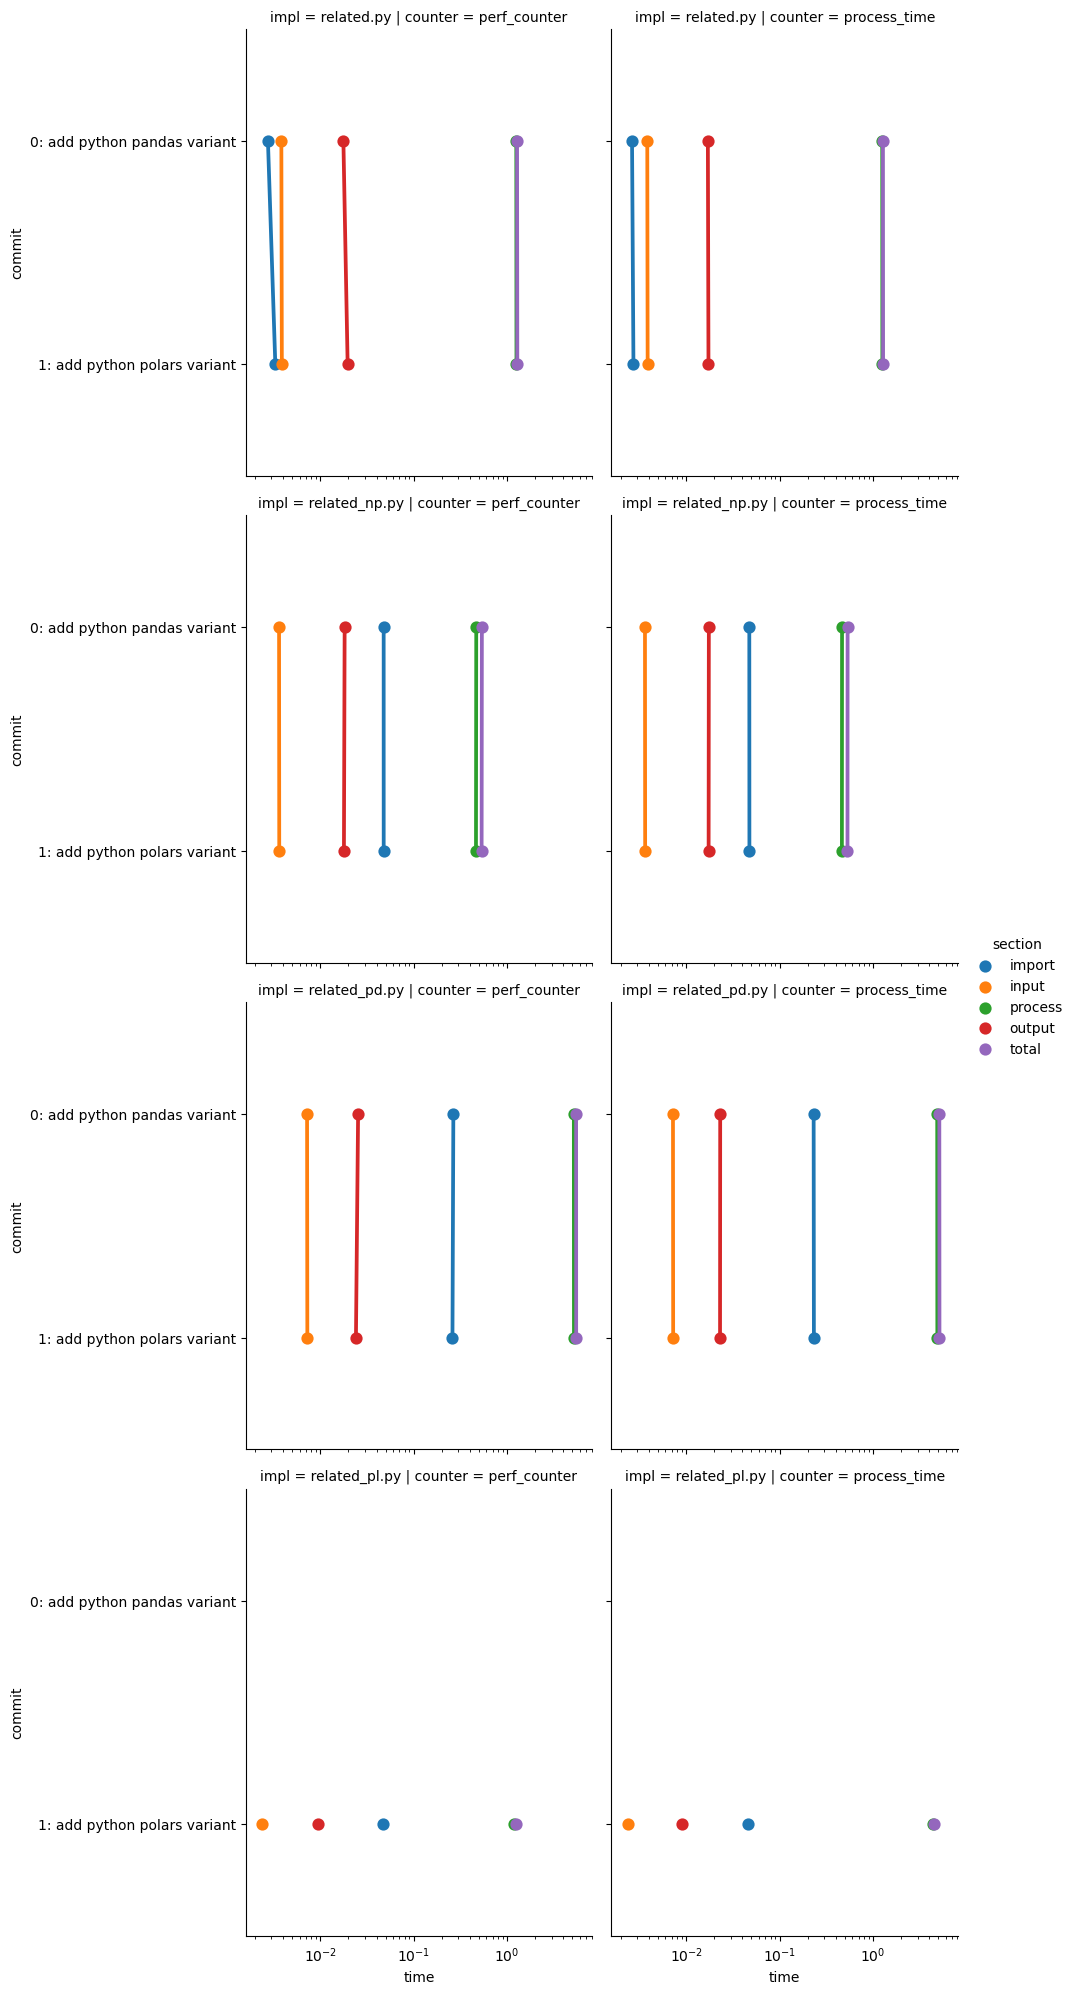

In [18]:
plot(times_df)

In [19]:
times_numba = collect_times(
    ["python..numba",], "related_numba.py",
    5,
    input_columns=["counter", "import", "compile", "input", "process", "output"],
    time_columns=["import", "compile", "input", "process", "output"],
)
times_numba


0: add another numpy solution (without matrix)
related_numba.py
perf_counter	0.07277320802677423	2.9999646358191967e-06	0.003823709033895284	0.8938750000088476	0.018590416002552956
process_time	0.049956	2.000000000002e-06	0.003802999999999994	0.8938710000000001	0.01691599999999993



  0%|          | 0/5 [00:00<?, ?it/s]


1: accelerate with numba JIT
related_numba.py
perf_counter	0.4098430830053985	0.35561287502059713	0.003902000025846064	0.16961524996440858	0.016567374987062067
process_time	0.176281	0.241579	0.0039020000000000166	0.16961499999999996	0.016568000000000027



  0%|          | 0/5 [00:00<?, ?it/s]

,counter,import,compile,input,process,output,impl,commit,total
0,perf_counter,0.048987,0.000006,0.003575,0.892160,0.017018,related_numba.py,0: add another numpy solution (without matrix),0.961746
1,process_time,0.049059,0.000003,0.003575,0.892149,0.017019,related_numba.py,0: add another numpy solution (without matrix),0.961805
2,perf_counter,0.046777,0.000007,0.003520,0.893161,0.016936,related_numba.py,0: add another numpy solution (without matrix),0.960400
3,process_time,0.046870,0.000002,0.003521,0.893118,0.016934,related_numba.py,0: add another numpy solution (without matrix),0.960445
4,perf_counter,0.047249,0.000004,0.003618,0.892072,0.019545,related_numba.py,0: add another numpy solution (without matrix),0.962488
5,process_time,0.047389,0.000002,0.003619,0.892072,0.017339,related_numba.py,0: add another numpy solution (without matrix),0.960421
6,perf_counter,0.046783,0.000006,0.003524,0.893240,0.017161,related_numba.py,0: add another numpy solution (without matrix),0.960714
7,process_time,0.046931,0.000002,0.003525,0.893233,0.017158,related_numba.py,0: add another numpy solution (without matrix),0.960849
8,perf_counter,0.046973,0.000004,0.003527,0.891199,0.017035,related_numba.py,0: add another numpy solution (without matrix),0.958738
9,process_time,0.047061,0.000003,0.003526,0.891206,0.017030,related_numba.py,0: add another numpy solution (without matrix),0.958826


In [22]:
report(times_numba)

import  \
impl             counter      commit                                                        
related_numba.py perf_counter 0: add another numpy solution (without matrix)   47.35±0.93   
                              1: accelerate with numba JIT                    143.58±0.35   
                 process_time 0: add another numpy solution (without matrix)   47.46±0.92   
                              1: accelerate with numba JIT                    143.71±0.36   

                                                                                      compile  \
impl             counter      commit                                                            
related_numba.py perf_counter 0: add another numpy solution (without matrix)    0.0052±0.0014   
                              1: accelerate with numba JIT                          218.5±2.8   
                 process_time 0: add another numpy solution (without matrix)  0.00240±0.00055   
                              1: accelerate with numba JIT                          218.3±2.5   

                                                                                    input  \
impl             counter      commit                                                        
related_numba.py perf_counter 0: add another numpy solution (without matrix)  3.553±0.043   
                              1: accelerate with numba JIT                    3.872±0.073   
                 process_time 0: add another numpy solution (without matrix)  3.553±0.043   
                              1: accelerate with numba JIT                    3.871±0.073   

                                                                                  process  \
impl             counter      commit                                                        
related_numba.py perf_counter 0: add another numpy solution (without matrix)  892.37±0.85   
                              1: accelerate with numba JIT                    169.48±0.39   
                 process_time 0: add another numpy solution (without matrix)  892.36±0.84   
                              1: accelerate with numba JIT                    169.48±0.38   

                                                                                  output  \
impl             counter      commit                                                       
related_numba.py perf_counter 0: add another numpy solution (without matrix)    17.5±1.1   
                              1: accelerate with numba JIT                    16.74±0.39   
                 process_time 0: add another numpy solution (without matrix)  17.10±0.16   
                              1: accelerate with numba JIT                    16.60±0.14   

                                                                                  total  
impl             counter      commit                                                     
related_numba.py perf_counter 0: add another numpy solution (without matrix)  960.8±1.4  
                              1: accelerate with numba JIT                    552.1±2.8  
                 process_time 0: add another numpy solution (without matrix)  960.5±1.1  
                              1: accelerate with numba JIT                    551.9±2.6

/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/timing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

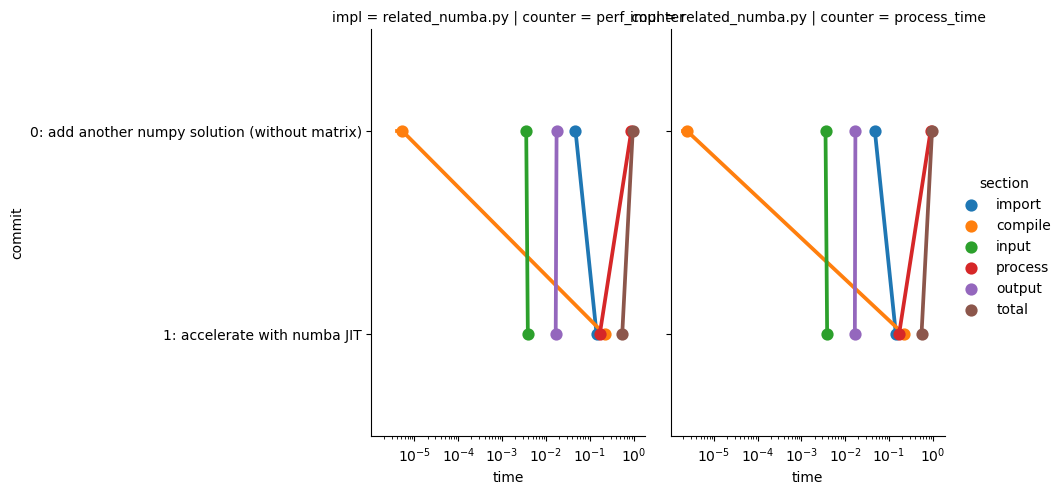

In [23]:
plot(times_numba)
